# Multi-Layer Perceptrons (MLPs) — Theory and Practice

**Contents**
1. What is a perceptron? — single neuron
2. Activation functions (intuition + plots)
3. MLP architecture, notation, and forward pass (formulas)
4. Loss functions and training objective
5. Backpropagation — derivation and intuition
6. Implementing an MLP from scratch (NumPy) — training on XOR
7. Using `scikit-learn`'s `MLPClassifier`
8. PyTorch example (runs only if `torch` is available)

## Prerequisites

If you need to install packages, run:
```bash
# Only run if needed:
# pip install numpy matplotlib scikit-learn
# # Optional for the PyTorch example:
# pip install torch torchvision
```

We will use:
- `numpy` for implementing networks from scratch
- `matplotlib` for plots
- `scikit-learn` for a production-ready `MLPClassifier`
- `torch` optionally for a PyTorch example (the cell is guarded and will only run if `torch` is installed)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
np.random.seed(42)
%matplotlib inline

## 1) The Perceptron — single neuron

A **perceptron** (single neuron) computes a weighted sum of inputs plus a bias and passes it through an activation function:
\begin{align*}
z &= \mathbf{w}^\top \mathbf{x} + b \\[4pt]
a &= \phi(z)
\end{align*}

Commonly for classification we use a step activation for the original perceptron; modern neural networks use differentiable activations (sigmoid, tanh, ReLU, etc.).

Perceptron learning rule (simple case) updates weights to reduce classification errors, but it only converges for linearly separable data.


## 2) Activation functions — intuition and formulas

Common activations and why we use them:

- **Sigmoid (logistic):** $\sigma(z) = \dfrac{1}{1 + e^{-z}}$. Outputs in $(0,1)$; historically used for binary outputs. Can saturate for large |z| leading to vanishing gradients.
- **Tanh:** $\tanh(z) = \dfrac{e^{z} - e^{-z}}{e^{z} + e^{-z}}$. Outputs in $(-1,1)$; zero-centered which helps optimization vs sigmoid.
- **ReLU (Rectified Linear Unit):** $\text{ReLU}(z) = \max(0,z)$. Simple, efficient, mitigates vanishing gradients for positive z.
- **Leaky ReLU:** $\text{LeakyReLU}(z) = \max(\alpha z, z)$ (e.g., $\alpha=0.01$) — avoids dead neurons.
- **Softmax:** For multi-class outputs: $$\mathrm{softmax}(z)_k = \frac{e^{z_k}}{\sum_{j} e^{z_j}}$$ producing a probability distribution.

Let's visualize these activations.


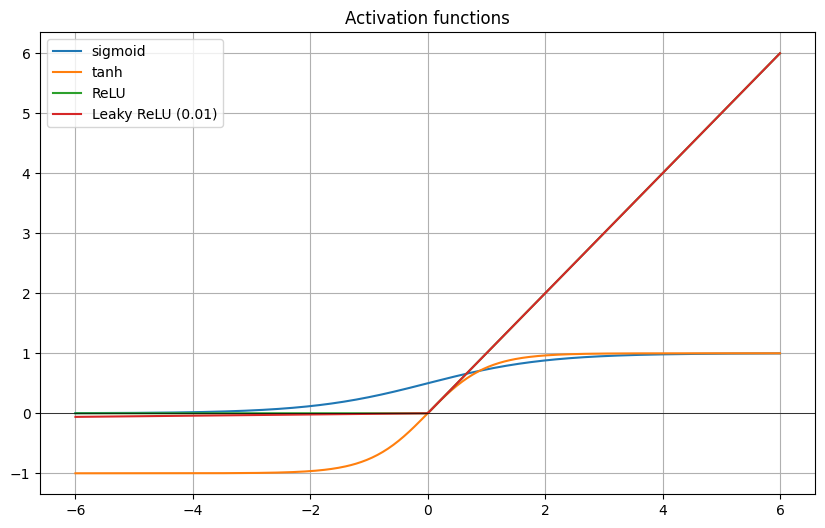

In [2]:
# Plot activation functions
z = np.linspace(-6,6,400)
sig = 1/(1+np.exp(-z))
tanh = np.tanh(z)
relu = np.maximum(0,z)
leaky = np.where(z>0, z, 0.01*z)

plt.figure(figsize=(10,6))
plt.plot(z, sig, label='sigmoid')
plt.plot(z, tanh, label='tanh')
plt.plot(z, relu, label='ReLU')
plt.plot(z, leaky, label='Leaky ReLU (0.01)')
plt.axhline(0, color='k', linewidth=0.5)
plt.legend()
plt.title('Activation functions')
plt.grid(True)
plt.show()

## 3) MLP architecture, notation, and forward pass

An MLP with $L$ layers (counting only layers with parameters) maps input $\mathbf{x}$ to output $\hat{\mathbf{y}}$ via:
\begin{align*}
\mathbf{z}^{(1)} &= \mathbf{W}^{(1)}\mathbf{x} + \mathbf{b}^{(1)}, \quad \mathbf{a}^{(1)} = \phi^{(1)}(\mathbf{z}^{(1)}) \\[4pt]
\mathbf{z}^{(2)} &= \mathbf{W}^{(2)}\mathbf{a}^{(1)} + \mathbf{b}^{(2)}, \quad \mathbf{a}^{(2)} = \phi^{(2)}(\mathbf{z}^{(2)}) \\[4pt]
&\ \ \vdots \\[4pt]
\mathbf{z}^{(L)} &= \mathbf{W}^{(L)}\mathbf{a}^{(L-1)} + \mathbf{b}^{(L)}, \quad \hat{\mathbf{y}} = \phi^{(L)}(\mathbf{z}^{(L)})
\end{align*}

- $\mathbf{W}^{(l)}$ is the weight matrix for layer $l$,
- $\mathbf{b}^{(l)}$ is the bias vector,
- $\phi^{(l)}$ is the activation function for layer $l$.

For classification:
- Binary: final activation often sigmoid (or a single logit with BCE loss).
- Multi-class: final activation softmax with cross-entropy loss.

Loss (e.g., cross-entropy) is minimized w.r.t. all weights using gradient-based optimization (backpropagation + SGD/Adam).


## 4) Loss functions (objectives)

- **Mean Squared Error (MSE)** for regression: $$\mathcal{L}_{\text{MSE}} = \frac{1}{n}\sum_{i=1}^n \|\mathbf{y}^{(i)} - \hat{\mathbf{y}}^{(i)}\|^2$$
- **Binary Cross-Entropy** for binary classification: $$\mathcal{L}_{\text{BCE}} = -\frac{1}{n}\sum_{i=1}^n \big[y^{(i)}\log \hat{y}^{(i)} + (1-y^{(i)})\log(1-\hat{y}^{(i)})\big]$$
- **Categorical Cross-Entropy (softmax + CE)** for multi-class: $$\mathcal{L}_{\text{CE}} = -\frac{1}{n}\sum_{i=1}^n \sum_{k} y_k^{(i)} \log \hat{y}_k^{(i)}$$

Cross-entropy combined with softmax is the standard choice for multi-class classification.


## 5) Backpropagation — intuition and key formulas

Backpropagation applies the chain rule to compute gradients of the loss w.r.t. parameters efficiently by propagating errors from the output layer backward.

For a single training example (omitting superscript (i) for clarity), denote:
- $\delta^{(L)} = \frac{\partial \mathcal{L}}{\partial \mathbf{z}^{(L)}}$ (error at output layer)
- For layer $l$, gradients are:
\begin{align*}
\frac{\partial \mathcal{L}}{\partial \mathbf{W}^{(l)}} &= \delta^{(l)} \big(\mathbf{a}^{(l-1)}\big)^\top \\[4pt]
\frac{\partial \mathcal{L}}{\partial \mathbf{b}^{(l)}} &= \delta^{(l)}
\end{align*}
and the error propagates as:
\begin{align*}
\delta^{(l)} &= \big(\mathbf{W}^{(l+1)}\big)^\top \delta^{(l+1)} \odot \phi'(\mathbf{z}^{(l)})
\end{align*}
where $\odot$ denotes element-wise product and $\phi'$ is the derivative of the activation.

For softmax + cross-entropy, $\delta^{(L)} = \hat{\mathbf{y}} - \mathbf{y}$ which is a convenient simplification.


## 6) Implementing an MLP from scratch (NumPy)

We implement a small MLP with one hidden layer and train it on the XOR problem — a classic example that is **not** linearly separable and requires a hidden layer.


Epoch 0, loss: 0.6941
Epoch 500, loss: 0.0157
Epoch 1000, loss: 0.0060
Epoch 1500, loss: 0.0037
Epoch 2000, loss: 0.0027
Epoch 2500, loss: 0.0021
Epoch 3000, loss: 0.0017
Epoch 3500, loss: 0.0014
Epoch 4000, loss: 0.0012
Epoch 4500, loss: 0.0011


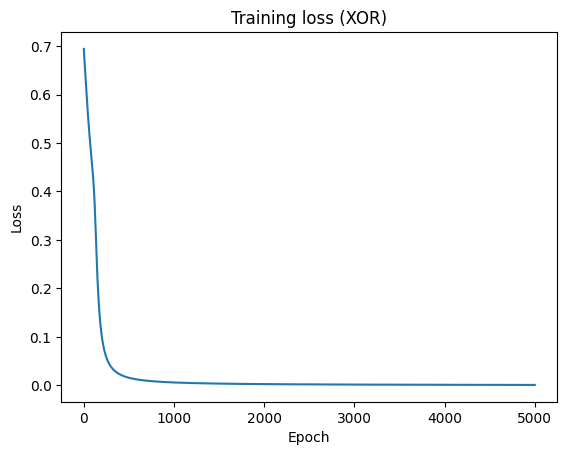

Predictions: [[0 1 1 0]]
True labels: [[0 1 1 0]]


In [3]:
# Simple MLP from scratch (one hidden layer)
class SimpleMLP:
    def __init__(self, n_inputs, n_hidden, n_outputs, lr=0.1, epochs=1000, activation='tanh', seed=42):
        np.random.seed(seed)
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_outputs = n_outputs
        # Weight initialization (small random values)
        self.W1 = np.random.randn(n_hidden, n_inputs) * np.sqrt(2. / n_inputs)
        self.b1 = np.zeros((n_hidden,1))
        self.W2 = np.random.randn(n_outputs, n_hidden) * np.sqrt(2. / n_hidden)
        self.b2 = np.zeros((n_outputs,1))
        self.lr = lr
        self.epochs = epochs
        if activation == 'tanh':
            self.act = np.tanh
            self.act_prime = lambda x: 1 - np.tanh(x)**2
        elif activation == 'relu':
            self.act = lambda x: np.maximum(0,x)
            self.act_prime = lambda x: (x > 0).astype(float)
        else:
            raise ValueError('Unsupported activation')

    def forward(self, X):
        Z1 = self.W1.dot(X) + self.b1
        A1 = self.act(Z1)
        Z2 = self.W2.dot(A1) + self.b2
        A2 = 1/(1+np.exp(-Z2))  # sigmoid for binary output
        cache = (X, Z1, A1, Z2, A2)
        return A2, cache

    def compute_loss(self, Y, A2):
        m = Y.shape[1]
        # binary cross-entropy
        eps = 1e-8
        loss = -np.sum(Y*np.log(A2+eps) + (1-Y)*np.log(1-A2+eps)) / m
        return loss

    def backward(self, cache, Y):
        X, Z1, A1, Z2, A2 = cache
        m = X.shape[1]
        dZ2 = A2 - Y  # for BCE with sigmoid
        dW2 = (1/m) * dZ2.dot(A1.T)
        db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)
        dA1 = self.W2.T.dot(dZ2)
        dZ1 = dA1 * self.act_prime(Z1)
        dW1 = (1/m) * dZ1.dot(X.T)
        db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)
        # update
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

    def fit(self, X, Y, verbose=False):
        losses = []
        for i in range(self.epochs):
            A2, cache = self.forward(X)
            loss = self.compute_loss(Y, A2)
            losses.append(loss)
            self.backward(cache, Y)
            if verbose and i % (max(1,self.epochs//10)) == 0:
                print(f'Epoch {i}, loss: {loss:.4f}')
        return losses

    def predict(self, X):
        A2, _ = self.forward(X)
        return (A2 > 0.5).astype(int)

# Prepare XOR dataset
X = np.array([[0,0,1,1],[0,1,0,1]])  # shape (2,4)
Y = np.array([[0,1,1,0]])            # shape (1,4)

mlp = SimpleMLP(n_inputs=2, n_hidden=4, n_outputs=1, lr=0.5, epochs=5000, activation='tanh')
losses = mlp.fit(X, Y, verbose=True)

# Plot loss
import matplotlib.pyplot as plt
plt.plot(losses)
plt.title('Training loss (XOR)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluate
preds = mlp.predict(X)
print('Predictions:', preds)
print('True labels:', Y)

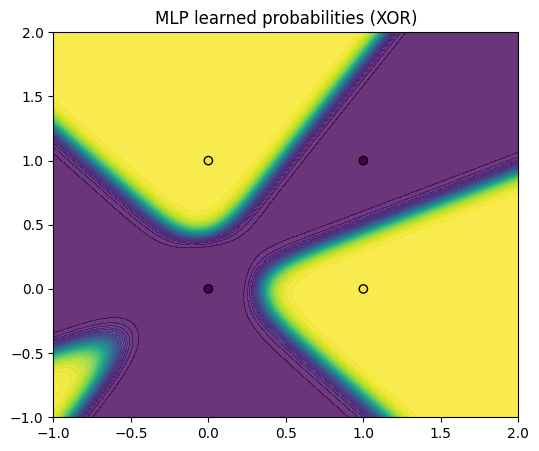

In [4]:
# Visualize learned function over grid
xx, yy = np.meshgrid(np.linspace(-1,2,200), np.linspace(-1,2,200))
grid = np.c_[xx.ravel(), yy.ravel()].T
probs, _ = mlp.forward(grid)
Z = probs.reshape(xx.shape)
plt.figure(figsize=(6,5))
plt.contourf(xx, yy, Z, levels=50, alpha=0.8)
plt.scatter(X[0,:], X[1,:], c=Y.ravel(), edgecolors='k')
plt.title('MLP learned probabilities (XOR)')
plt.show()

## 7) Using `scikit-learn`'s `MLPClassifier`

`scikit-learn` provides `MLPClassifier` which is convenient for small-to-medium problems. It supports multiple hidden layers, activation choices, L2 regularization, and different solvers (adam, lbfgs, sgd).

Let's train an MLP on the `make_moons` dataset and evaluate it.


In [7]:
# make_moons example
X_moons, y_moons = make_moons(n_samples=500, noise=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_moons, y_moons, test_size=0.3, random_state=1)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

clf = MLPClassifier(hidden_layer_sizes=(50,25), activation='tanh', solver='adam',
                    alpha=1e-3, batch_size=32, learning_rate_init=0.01, max_iter=1000, random_state=1)
clf.fit(X_train_s, y_train)

print('Test accuracy:', clf.score(X_test_s, y_test))
print('\nClassification report:\n', classification_report(y_test, clf.predict(X_test_s)))

Test accuracy: 0.9733333333333334

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        73
           1       0.97      0.97      0.97        77

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



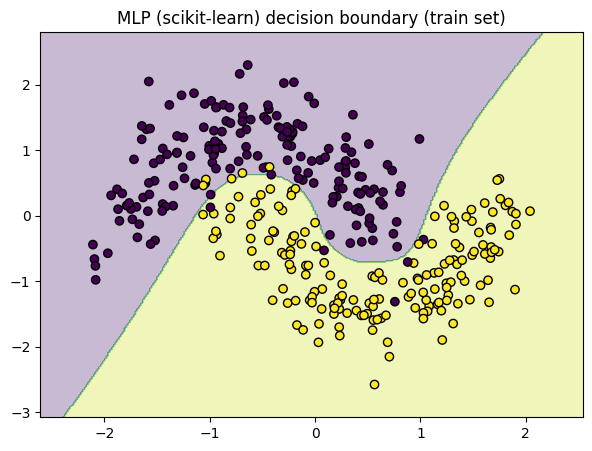

In [8]:
# plot decision boundary
def plot_decision(clf, X, y, title='Decision boundary'):
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(7,5))
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:,0], X[:,1], c=y, edgecolors='k')
    plt.title(title)
    plt.show()

plot_decision(clf, X_train_s, y_train, title='MLP (scikit-learn) decision boundary (train set)')

### Hyperparameter tuning (example)

We can use `GridSearchCV` to tune hidden layer sizes, `alpha` (L2 penalty), and learning rate. For brevity we show a small grid.


In [9]:
param_grid = {
    'hidden_layer_sizes': [(20,), (50,20)],
    'alpha': [1e-4, 1e-3],
    'learning_rate_init': [0.001, 0.01]
}
grid = GridSearchCV(MLPClassifier(max_iter=800, random_state=1), param_grid, cv=3, n_jobs=-1)
grid.fit(X_train_s, y_train)
print('Best params:', grid.best_params_)
print('Best CV score:', grid.best_score_)

/Users/albertocasagrande/opt/anaconda3/envs/deeplearning/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/albertocasagrande/opt/anaconda3/envs/deeplearning/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(


Best params: {'alpha': 0.0001, 'hidden_layer_sizes': (20,), 'learning_rate_init': 0.01}
Best CV score: 0.9599174771588564


## 8) PyTorch example — small MLP

The following cell runs **only** if `torch` is installed in your environment. It demonstrates building a small MLP in PyTorch, training it on `make_moons`, and reporting accuracy. If `torch` is not available, the cell will print a message and skip.


In [ ]:
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    X_t = torch.tensor(X_train_s, dtype=torch.float32).to(device)
    y_t = torch.tensor(y_train, dtype=torch.long).to(device)
    X_val = torch.tensor(X_test_s, dtype=torch.float32).to(device)
    y_val = torch.tensor(y_test, dtype=torch.long).to(device)

    class SmallNet(nn.Module):
        def __init__(self, input_dim=2):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim, 50),
                nn.Tanh(),
                nn.Linear(50, 25),
                nn.Tanh(),
                nn.Linear(25, 2)
            )
        def forward(self, x):
            return self.net(x)

    model = SmallNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    epochs = 200

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_t)
        loss = criterion(outputs, y_t)
        loss.backward()
        optimizer.step()
        if epoch % 50 == 0:
            model.eval()
            with torch.no_grad():
                preds = model(X_val).argmax(dim=1)
                acc = (preds == y_val).float().mean().item()
            print(f'Epoch {epoch}, loss {loss.item():.4f}, val acc {acc:.4f}')

    model.eval()
    with torch.no_grad():
        preds = model(X_val).argmax(dim=1)
        print('Final val acc:', (preds == y_val).float().mean().item())

except Exception as e:
    print('PyTorch not available or an error occurred — skipping PyTorch example.')
    print('Error:', e)

tensor([[ 3.3086e-02, -1.5791e-01],
        [ 1.2624e-01, -1.0722e-01],
        [ 1.3189e-01, -6.7316e-02],
        [ 9.0503e-02, -1.6028e-01],
        [-2.3555e-02, -1.5704e-01],
        [ 4.5622e-02, -1.6120e-01],
        [ 4.2197e-02, -1.5677e-01],
        [-4.6454e-02, -8.3066e-02],
        [-5.8823e-02, -1.8882e-01],
        [-7.2880e-02, -1.8135e-01],
        [ 7.0773e-02, -7.0838e-02],
        [ 1.1925e-01, -6.6754e-02],
        [ 4.7713e-02, -7.9093e-02],
        [ 3.2344e-02, -1.7030e-01],
        [-1.2158e-01, -2.0352e-01],
        [-3.2341e-02, -1.6881e-01],
        [ 1.0833e-02, -9.2919e-02],
        [-3.9355e-02, -7.0589e-02],
        [-6.7128e-02, -1.1929e-01],
        [ 2.4140e-02, -1.4011e-01],
        [ 1.1982e-01, -6.4337e-02],
        [-5.2303e-03, -1.6621e-01],
        [ 3.8870e-04, -1.6846e-01],
        [-6.6251e-02, -9.6734e-02],
        [ 1.3151e-01, -6.5065e-02],
        [-3.7564e-02, -1.5009e-01],
        [ 5.5868e-02, -1.8244e-01],
        [-3.1359e-02, -1.795